In [1]:
### Team Name: NobodyExpectsTheSystemIntegration
### Design and Programming by Mojtaba Valipour @ Shiraz University, Udacity 

In [3]:
'''
Resources:
    - https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
    - https://stackoverflow.com/questions/44274701/make-predictions-using-a-tensorflow-graph-from-a-keras-model
    - https://github.com/burgalon/deep-learning-traffic-lights/blob/master/train.py
    - https://stackoverflow.com/questions/19560044/how-to-concatenate-element-wise-two-lists-in-python
    - https://www.tensorflow.org
'''
print('Copyright is important @2017')

Copyright is important @2017


In [4]:
import tensorflow as tf
import os
%matplotlib inline
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16049774782218868851
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 12051077530
locality {
  bus_id: 1
}
incarnation: 15932771357308570129
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:0a:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 12051077530
locality {
  bus_id: 1
}
incarnation: 771719171356172181
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:09:00.0"
, name: "/gpu:2"
device_type: "GPU"
memory_limit: 12049085236
locality {
  bus_id: 1
}
incarnation: 9510362175555347402
physical_device_desc: "device: 2, name: GeForce GTX TITAN X, pci bus id: 0000:06:00.0"
, name: "/gpu:3"
device_type: "GPU"
memory_limit: 12047777792
locality {
  bus_id: 1
}
incarnation: 13433773316870221928
physical_device_desc: "device: 3, name: GeForce GTX TITAN X, pci bus id: 0000:05:00.0"
]


# Config

In [5]:
import os

from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.optimizers import Adam

NUM_CHANNELS = 3
IMAGE_WIDTH = 224 
IMAGE_HEIGHT = 224 
NUM_CLASSES = 2

Using TensorFlow backend.


# Helper function

In [6]:
# keras image generator
def get_generator(directory, train):
    if train:
        datagen = ImageDataGenerator(
          rescale=1./255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    
    return datagen.flow_from_directory(
        directory=directory,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=8,
        class_mode='categorical')

In [7]:
import matplotlib.pyplot as plt
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], figsize=(20,12), grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figsize)
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize+1):
        img = figure.add_subplot(factors[0],factors[1],i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        #image = image[60:150,:]
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
#plotSpecialTool(centerImgs,labelsCSV["label"],factors=[3,4],thr=0.0,grayFlag=False) 

In [50]:
# load images
import cv2
import numpy as np
from scipy import misc
def loadImg(imgLoc):
    imageLocation = imgLoc
    image = misc.imread(imageLocation) #cv2.imread(imageLocation) # BGR
    #b,g,r = cv2.split(image)       # get b,g,r
    #image = cv2.merge([r,g,b])     # switch it to rgb

    if (image is None):
        print(imageLocation)
     
    image = cv2.resize(image, (224, 224))/255.
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
#numSample = 12
#centerImgs = np.array([loadImg(imgLoc) for imgLoc in labelsCSV['filename'][0:numSample]])

# Dataset

In [10]:
directory = './data/'
train_generator = get_generator(directory+'train', True)
validation_generator = get_generator(directory+'val', False)

Found 3922 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


# Model 

In [14]:
model = Sequential([
  Convolution2D(16, 3, 3, border_mode='same', subsample=(2, 2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), activation='relu'),
  MaxPooling2D(pool_size=(3, 3)),
  Dropout(0.2),

  Convolution2D(32, 3, 3, border_mode='same', activation='relu'),
  MaxPooling2D(pool_size=(3, 3)),
  Dropout(0.2),

  Convolution2D(64, 3, 3, border_mode='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),

  Flatten(),
  Dense(128, activation='tanh'),
  Dropout(0.5), # 0.3 works fine
  Dense(NUM_CLASSES, activation='softmax'),
])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 112, 112, 16)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 37, 37, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 37, 37, 16)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 37, 37, 32)    4640        dropout_1[0][0]                  
___________________________________________________________________________________________

In [15]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=Adam(lr=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
filepath="./logs/-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='auto')
tensorboard = keras.callbacks.TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)
callbacks = [checkpoint, tensorboard]

In [16]:
# balance dataset
#ls -al | grep ^[-] | wc -l # to count files
# Red: 2621/3973 =  , Non_Red: 1353/3973 = 

# manual
class_weight = {0:34 , 1:66}

# automate
#from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [20]:
import h5py
model.fit_generator(
  train_generator,
  samples_per_epoch=train_generator.N,
  nb_epoch=25,
  class_weight=class_weight,
  validation_data=validation_generator,
  nb_val_samples=validation_generator.N,
  callbacks=callbacks,
)

Epoch 1/25
3922/3922 [==============================] - 48s - loss: 13.9307 - acc: 0.8315 - val_loss: 0.4705 - val_acc: 0.6909
Epoch 2/25
3922/3922 [==============================] - 46s - loss: 6.2052 - acc: 0.9513 - val_loss: 0.4545 - val_acc: 0.7091
Epoch 3/25
3922/3922 [==============================] - 48s - loss: 5.1443 - acc: 0.9597 - val_loss: 0.2837 - val_acc: 0.9364
Epoch 4/25
3922/3922 [==============================] - 47s - loss: 4.3770 - acc: 0.9681 - val_loss: 0.1029 - val_acc: 1.0000
Epoch 5/25
3922/3922 [==============================] - 48s - loss: 4.1585 - acc: 0.9707 - val_loss: 0.1317 - val_acc: 0.9818
Epoch 6/25
3922/3922 [==============================] - 47s - loss: 2.8678 - acc: 0.9791 - val_loss: 0.1203 - val_acc: 0.9818
Epoch 7/25
3922/3922 [==============================] - 47s - loss: 2.7744 - acc: 0.9806 - val_loss: 0.0917 - val_acc: 0.9818
Epoch 8/25
3922/3922 [==============================] - 48s - loss: 2.2001 - acc: 0.9862 - val_loss: 0.0932 - val_acc

In [22]:
model.evaluate_generator(validation_generator, val_samples=len(validation_generator.filenames))

[0.057692984152923933, 0.99090909090909096]

In [58]:
# load best weights for the model
from keras.models import load_model
model = load_model('./logs/-03-val_acc-1.00.hdf5')#('./logs/-24-val_acc-0.99.hdf5')

In [59]:
model.evaluate_generator(validation_generator, val_samples=len(validation_generator.filenames))

[0.11561148017644882, 1.0]

In [34]:
#labels = ['green', 'nolight', 'red', 'unidentified', 'yellow']
labels = ['Non-Red', 'Red']

In [73]:
# test the best model on the test pictures
%matplotlib inline
import glob
testDir = directory+'test/'
files = glob.glob(testDir+'*')
imgL = []
tlStatusL = []
statusProb = []
for file in files: 
    # load image
    img = loadImg(file)
    # predict 
    tlStatus = model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]),batch_size=1)
    # plot
    imgL.append(img)
    statusProb.append(tlStatus)
    tlStatusL.append(labels[np.argmax(tlStatus)])
    #print(labels[np.argmax(tlStatus)])
    #plt.imshow(img)

In [74]:
print(len(tlStatusL))

104


In [75]:
# merge two labels
# Ref: https://stackoverflow.com/questions/19560044/how-to-concatenate-element-wise-two-lists-in-python
newLabels = ["%s-%s" % t for t in zip(tlStatusL, statusProb)]

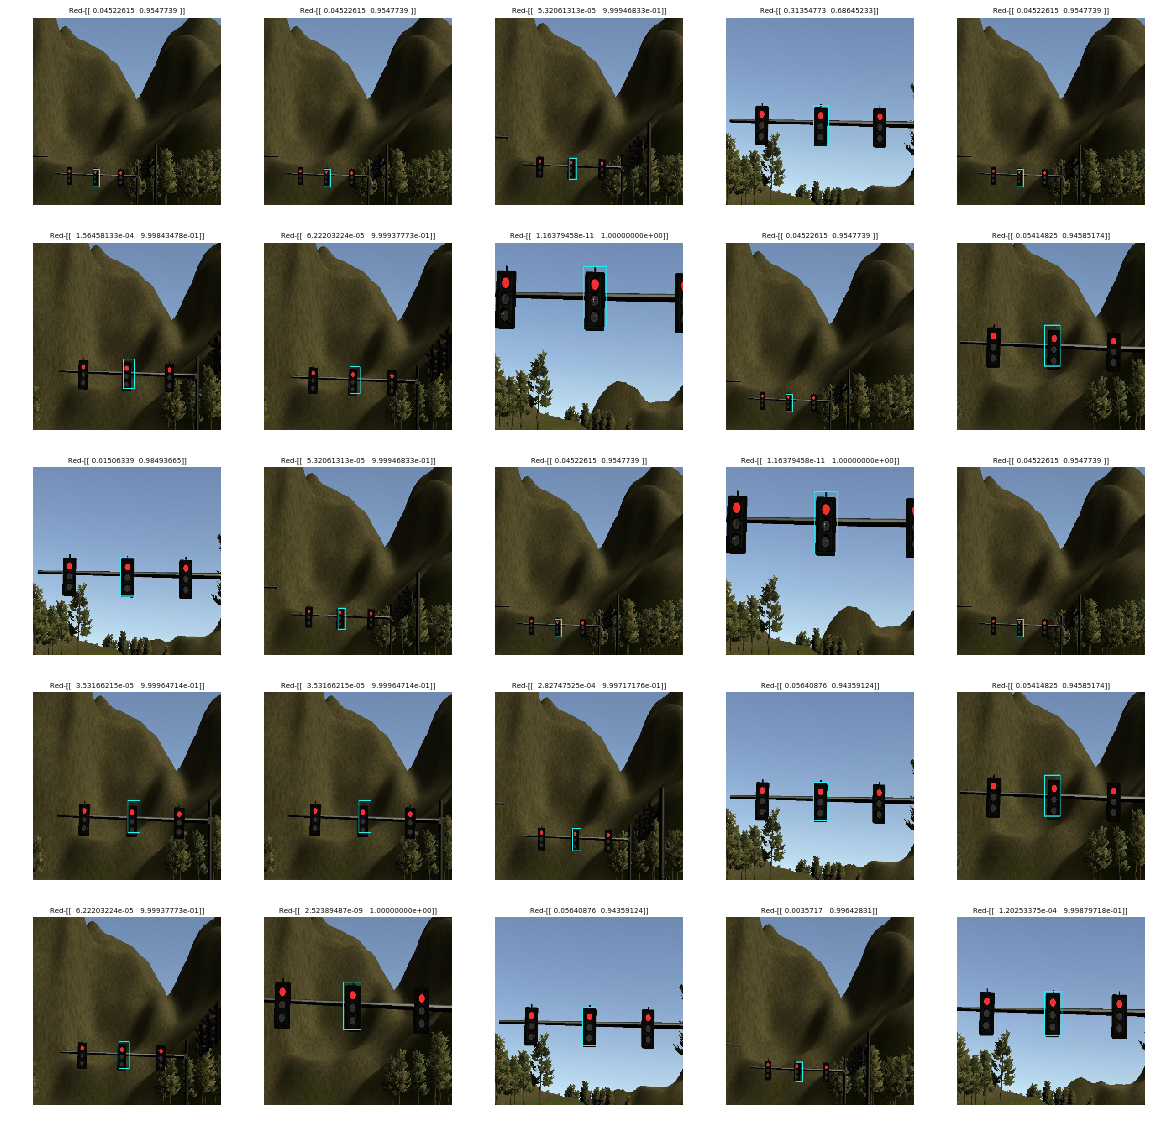

In [76]:
plotSpecialTool(np.array(imgL[0:25]),np.array(newLabels[0:25]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 

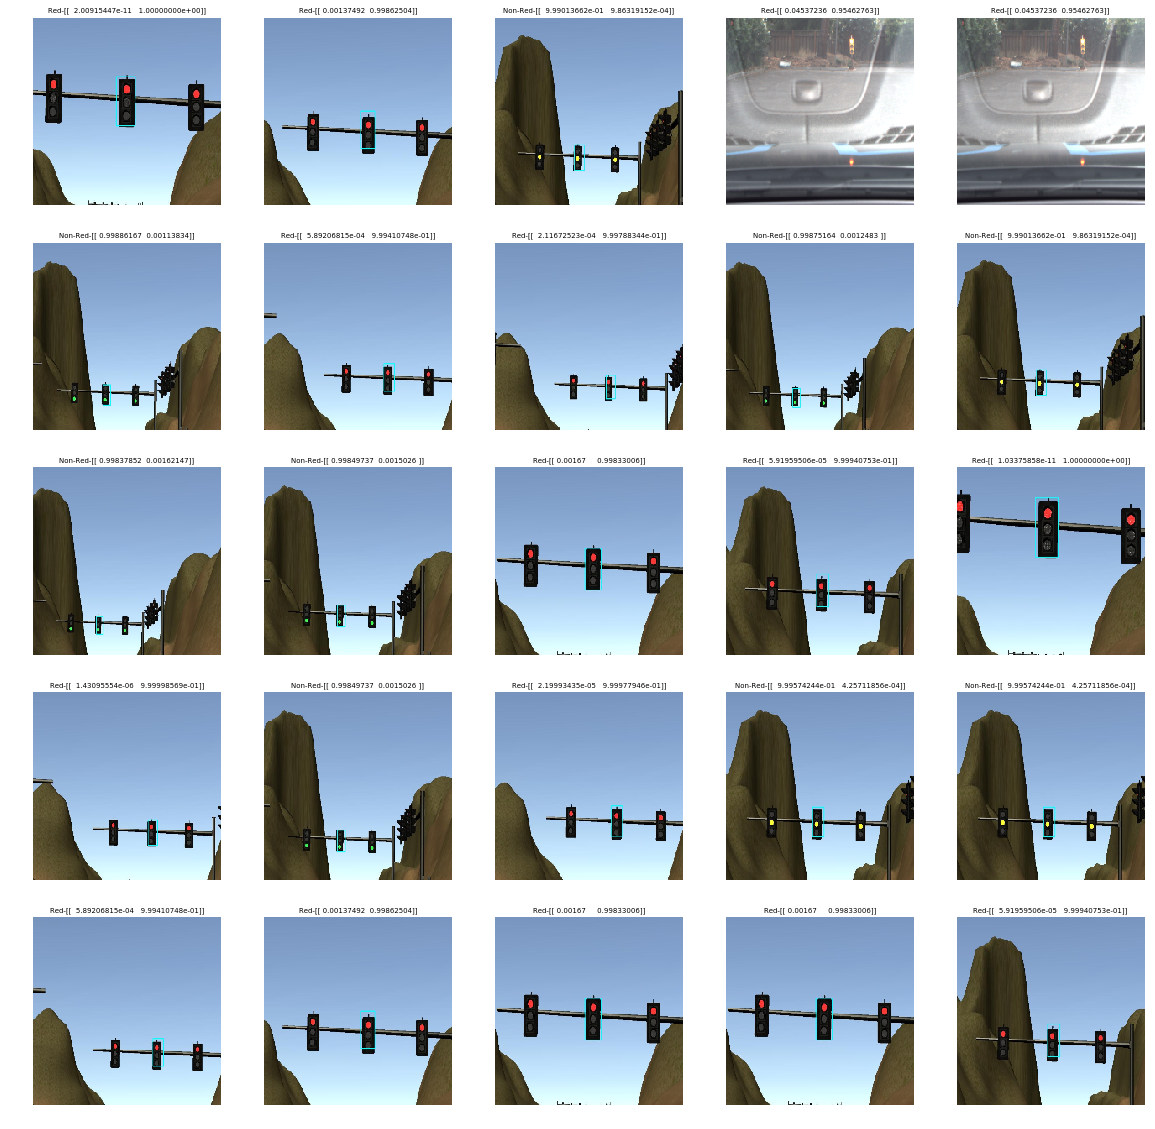

In [77]:
plotSpecialTool(np.array(imgL[25:50]),np.array(newLabels[25:50]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 

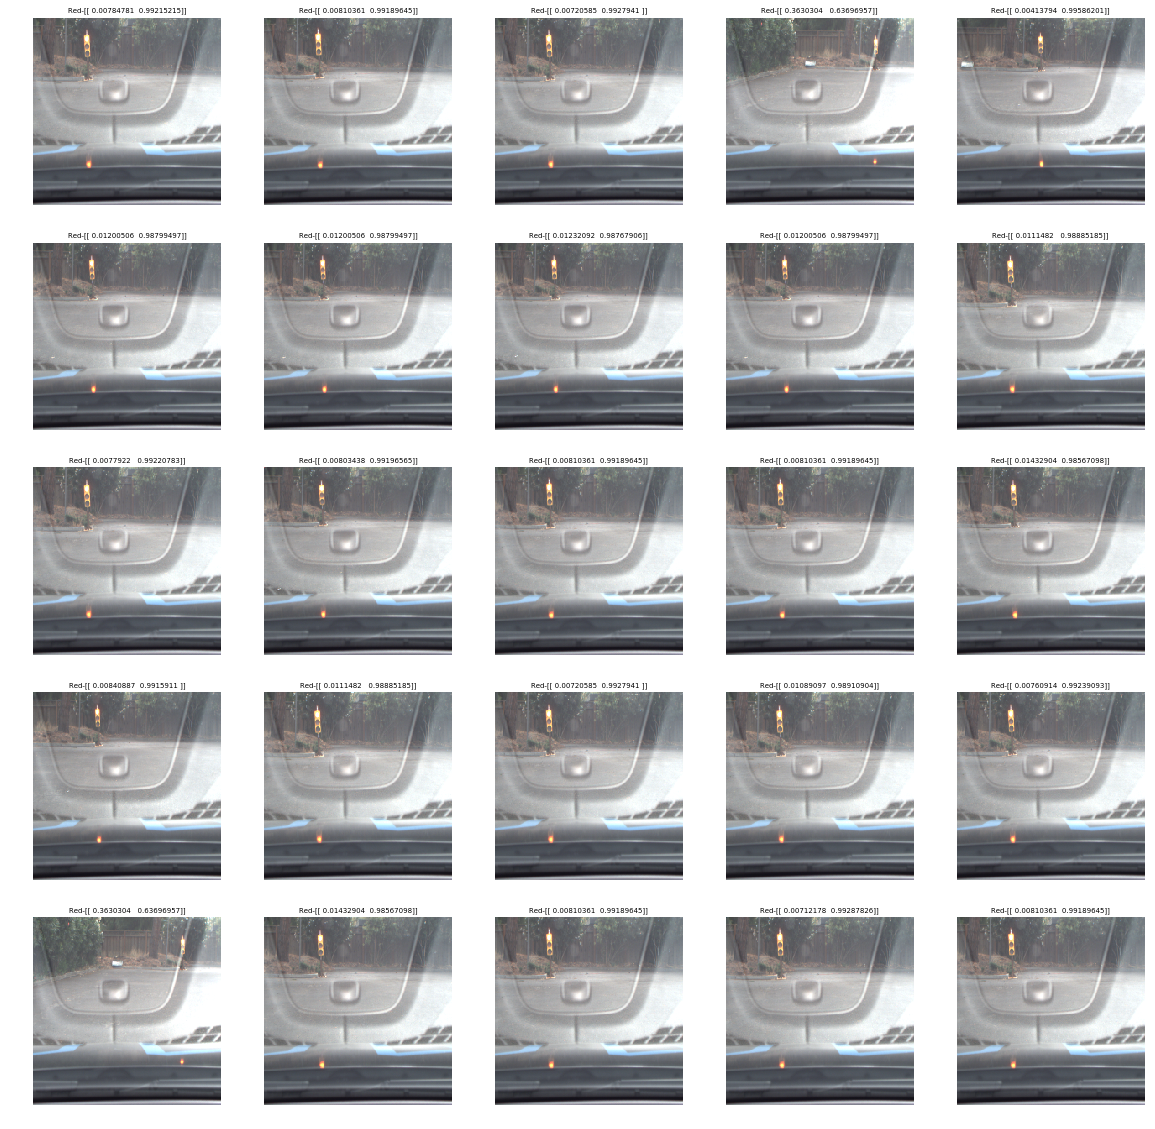

In [78]:
plotSpecialTool(np.array(imgL[50:75]),np.array(newLabels[50:75]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 

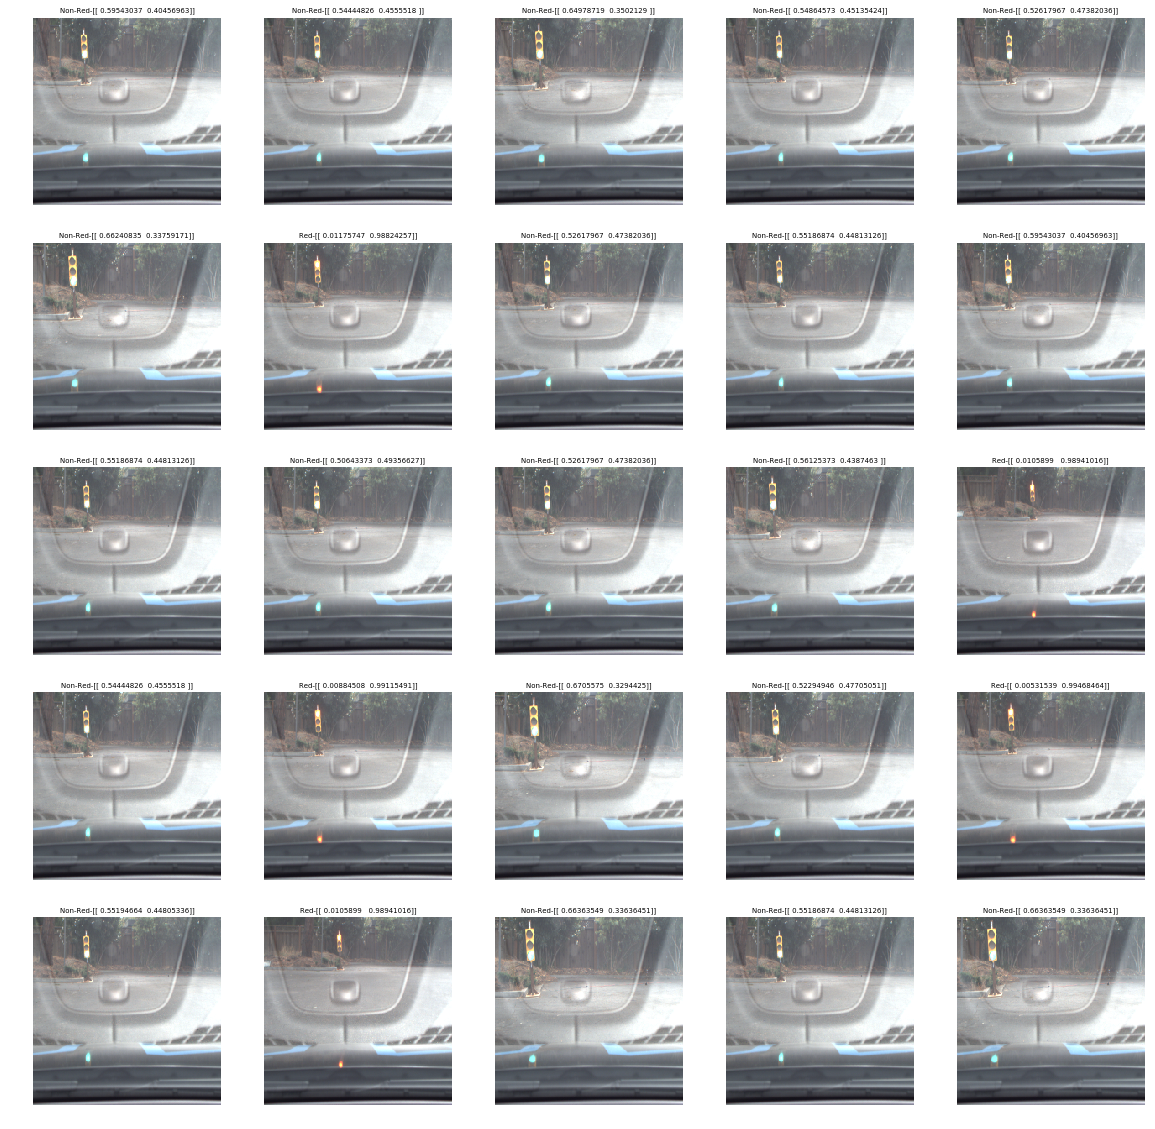

In [79]:
plotSpecialTool(np.array(imgL[75:100]),np.array(newLabels[75:100]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 

# Exporting the Model 

In [80]:
import tensorflow as tf
import numpy as np

# Create function to convert saved keras model to tensorflow graph
def convert_to_pb(weight_file,input_fld='',output_fld=''):

    import os
    import os.path as osp
    from tensorflow.python.framework import graph_util
    from tensorflow.python.framework import graph_io
    from keras.models import load_model
    from keras import backend as K


    # weight_file is a .h5 keras model file
    output_node_names_of_input_network = ["pred0"] 
    output_node_names_of_final_network = 'output_node'

    # change filename to a .pb tensorflow file
    output_graph_name = weight_file[:-2]+'pb'
    weight_file_path = osp.join(input_fld, weight_file)

    net_model = load_model(weight_file_path)

    num_output = len(output_node_names_of_input_network)
    pred = [None]*num_output
    pred_node_names = [None]*num_output

    for i in range(num_output):
        pred_node_names[i] = output_node_names_of_final_network+str(i)
        pred[i] = tf.identity(net_model.output[i], name=pred_node_names[i])

    sess = K.get_session()

    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
    graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
    print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))

    return output_fld+output_graph_name

In [81]:
tf_model_path = convert_to_pb('-01-val_acc-0.98.hdf5','./logs/','./logs/')

TypeError: __init__() takes at least 4 arguments (3 given)

In [160]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we can use again a convenient built-in function to import a graph_def into the 
    # current default Graph
    with tf.Graph().as_default() as graph:
        x = graph.graph_def_versions
        print('Graph Version is ', x)
        tf.import_graph_def(
            graph_def, 
            input_map=None, 
            return_elements=None, 
            name="prefix", 
            op_dict=None, 
            producer_op_list=None
        )
    dropout_name = graph.get_operations()[0].name+':0'
    input_name = graph.get_operations()[1].name+':0'
    output_name = graph.get_operations()[-1].name+':0'

    return graph, input_name, output_name, dropout_name

In [161]:
def predict(model_path, input_data):
    # load tf graph
    tf_model,tf_input,tf_output, dropout_name = load_graph(model_path)

    # Create tensors for model input and output
    x = tf_model.get_tensor_by_name(tf_input)
    y = tf_model.get_tensor_by_name(tf_output) 

    # Number of model outputs
    num_outputs = y.shape.as_list()[0]
    print('Number of outputs: ', num_outputs)
    predictions = np.zeros((input_data.shape[0],num_outputs))
    for i in range(input_data.shape[0]):        
        with tf.Session(graph=tf_model) as sess:
            #print(tf_model.get_operations()[1].name+':0')
            y_out = sess.run(y, feed_dict={x: input_data[i:i+1], dropout_name: 0})
            predictions[i] = y_out

    return predictions

In [162]:
test_data = imgL[101]
print(test_data.shape)
input2tfModel = test_data.reshape(1,test_data.shape[0], test_data.shape[1], test_data.shape[2])
print(input2tfModel.shape)

(224, 224, 3)
(1, 224, 224, 3)


In [163]:
tf_model_path = './logs/-01-val_acc-0.98.hdpb'
tf_predictions = predict(tf_model_path,input2tfModel)

Graph Version is  producer: 24

Number of outputs:  2


In [151]:
print(tf_predictions)

[[ 0.70913696  0.29086304]]
